<a href="https://colab.research.google.com/github/KoraySali/Dissertation_Archive/blob/main/model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wildfire Image Detection Dissertation**

This file will include a number of important architectures, code and technologies. A Convolutional Neural Network (CNN) model will be used for the image detection of "Fire", "Smoke", "No Fire/No Smoke" classification.

A chosen methodology will be followed in order to prevent confusion when writting and coding this dissertation. Various evaluation metrics will be used to evaluate the outcome of the image detection model along with a number of visualisations for readability.

For copy/version issues a Github repository has been set up in order to retain versions and prevent loss of work.

The runtime of this file will be GPU as a CPU runtime took a lot longer to perform/execute our code.

In [1]:
!git clone https://github.com/KoraySali/Dissertation_Archive.git

Cloning into 'Dissertation_Archive'...
remote: Enumerating objects: 11978, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 11978 (delta 38), reused 147 (delta 35), pack-reused 11820
Receiving objects: 100% (11978/11978), 54.95 MiB | 8.15 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Updating files: 100% (12005/12005), done.


In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project='Visualisations 1')

wandb: Currently logged in as: s5216739 (s5216739-koray). Use `wandb login --relogin` to force relogin


## Importing our modules and libraries



In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import os
import cv2
import matplotlib.image as mpimg
import random
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import shutil
from skimage import io, transform
import time
import tensorflow_hub as hub

%matplotlib inline

## Select images in the folder

In [3]:
def select_images_in_folder(preprocessed_folders):
    all_images = []

    for image_file in os.listdir(preprocessed_folders):
        read_image_path = os.path.join(preprocessed_folders, image_file)

        if os.path.isfile(read_image_path) is not None:
            single_image = mpimg.imread(read_image_path)
            all_images.append(single_image)
        else:
          print("Cannot return any images from " + preprocessed_folders)

    return all_images

In [4]:
preprocessed_train_fire_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_fire")
preprocessed_train_smoke_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_smoke")
preprocessed_train_nofire_nosmoke_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_nofire_nosmoke")

In [5]:
len(preprocessed_train_fire_images)

4000

# 1. Label Encoding 

In [6]:
from sklearn.preprocessing import LabelEncoder

label_names = ['Fire', 'No Fire or Smoke', 'Smoke']
Label_encoder = LabelEncoder()
Label_encoder.fit(label_names)

LabelEncoder()

In [7]:
train_fire_labels = Label_encoder.transform(['Fire'] * len(preprocessed_train_fire_images))
train_nofire_nosmoke_labels = Label_encoder.transform(['No Fire or Smoke'] * len(preprocessed_train_nofire_nosmoke_images))
train_smoke_labels =  Label_encoder.transform(['Smoke'] * len(preprocessed_train_smoke_images))

In [8]:
type(label_names)

list

Checks done below to ensure the correct coding of the labels.

In [9]:
train_fire_labels

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
preprocessed_train_fire_images[0].shape

(128, 128, 3)

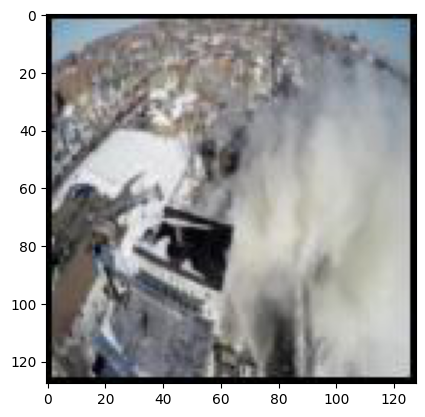

In [11]:
for single_image in preprocessed_train_fire_images[:10]:
  plt.imshow(single_image)

# 2. Training and testing split for our model to use

This is slightly redundant as we do this in our Google Colaboratory file so when running this code skip this as there becomes no need.

In [12]:
from sklearn.model_selection import train_test_split

# Combining the preprocessed images and their labels

X_train = np.concatenate([preprocessed_train_fire_images, preprocessed_train_smoke_images, preprocessed_train_nofire_nosmoke_images])
y_train = np.concatenate([train_fire_labels, train_smoke_labels, train_nofire_nosmoke_labels])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (9600, 128, 128, 3)
Train labels shape:  (9600,) int64
Test data shape:  (2400, 128, 128, 3)
Test labels shape:  (2400,)


In [ ]:
mean_pixel = X_train.mean(axis=(0, 1), keepdims=True)
std_pixel = X_train.std(axis=(0, 1), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

In [ ]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (9600, 128, 128, 3)
Train labels shape:  (9600,) int64
Test data shape:  (2400, 128, 128, 3)
Test labels shape:  (2400,)


# 3. Base Model Creation

Below is the first base model.

In [74]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="tanh", input_shape=[128,128,3]),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [75]:
base_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_base = base_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
150/150 [==============================] - 4s 21ms/step - loss: 3.2340 - accuracy: 0.3299 - val_loss: 1.1016 - val_accuracy: 0.3262
Epoch 2/10
150/150 [==============================] - 3s 18ms/step - loss: 1.0999 - accuracy: 0.3343 - val_loss: 1.0985 - val_accuracy: 0.3450
Epoch 3/10
150/150 [==============================] - 2s 16ms/step - loss: 1.1000 - accuracy: 0.3255 - val_loss: 1.1006 - val_accuracy: 0.3262
Epoch 4/10
150/150 [==============================] - 3s 17ms/step - loss: 1.1015 - accuracy: 0.3323 - val_loss: 1.1062 - val_accuracy: 0.3288
Epoch 5/10
150/150 [==============================] - 2s 17ms/step - loss: 1.1029 - accuracy: 0.3290 - val_loss: 1.1002 - val_accuracy: 0.3288
Epoch 6/10
150/150 [==============================] - 3s 17ms/step - loss: 1.1032 - accuracy: 0.3251 - val_loss: 1.1003 - val_accuracy: 0.3262
Epoch 7/10
150/150 [==============================] - 3s 18ms/step - loss: 1.1001 - accuracy: 0.3385 - val_loss: 1.1014 - val_accuracy: 0.3262

# 4. Complete Model

Below is the creation of our model and other relevant steps taken to achieve this.

## Data Augmentation

This actually decreased the accuracy when implemented.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 50,
    zoom_range = 0.5,
    width_shift_range=0.15,
    height_shift_range=0.1,
    horizontal_flip=True,  
    vertical_flip=True)

In [16]:
complete_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[128,128,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="LeakyReLU"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="LeakyReLU"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="LeakyReLU"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="LeakyReLU"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=1028, kernel_size=3, padding="same", activation="LeakyReLU"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=1028, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=2056, kernel_size=3, padding="same", activation="LeakyReLU"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=2056, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1028, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [17]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)
complete_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), metrics=['accuracy'])
history_complete = complete_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test)) #, callbacks=[callback]

Epoch 1/10
150/150 [==============================] - 62s 270ms/step - loss: 0.3273 - accuracy: 0.8793 - val_loss: 1.9013 - val_accuracy: 0.5508
Epoch 2/10
150/150 [==============================] - 42s 280ms/step - loss: 0.1763 - accuracy: 0.9367 - val_loss: 0.1763 - val_accuracy: 0.9375
Epoch 3/10
150/150 [==============================] - 42s 278ms/step - loss: 0.1558 - accuracy: 0.9446 - val_loss: 0.3110 - val_accuracy: 0.8921
Epoch 4/10
150/150 [==============================] - 39s 262ms/step - loss: 0.1372 - accuracy: 0.9529 - val_loss: 0.1677 - val_accuracy: 0.9463
Epoch 5/10
150/150 [==============================] - 42s 278ms/step - loss: 0.1190 - accuracy: 0.9581 - val_loss: 0.1251 - val_accuracy: 0.9538
Epoch 6/10
150/150 [==============================] - 39s 262ms/step - loss: 0.1160 - accuracy: 0.9593 - val_loss: 0.1389 - val_accuracy: 0.9492
Epoch 7/10
150/150 [==============================] - 42s 278ms/step - loss: 0.1133 - accuracy: 0.9620 - val_loss: 0.2407 - val_ac

# 5. Machine Learning Pipelines

In [18]:
train_features = complete_model.predict(X_train)
test_features = complete_model.predict(X_test)

75/75 [==============================] - 4s 49ms/step


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def make_pipeline(classifier, **kwargs):
    steps = [("scaler", StandardScaler()), ("classifier", classifier(**kwargs))]
    return Pipeline(steps)

In [20]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [21]:
rf_ensemble = make_pipeline(RandomForestClassifier, n_estimators=100)
svm_ensemble = make_pipeline(SVC, kernel="linear", C=1.0)
dt_ensemble = make_pipeline(DecisionTreeClassifier, max_depth=5, random_state=42)
knn_ensemble = make_pipeline(KNeighborsClassifier, n_neighbors=5)
nb_ensemble = make_pipeline(GaussianNB)
mlp_ensemble = make_pipeline(MLPClassifier, random_state=1, max_iter=300)

In [22]:
rf_ensemble.fit(train_features, y_train)
svm_ensemble.fit(train_features, y_train)
dt_ensemble.fit(train_features, y_train)
mlp_ensemble.fit(train_features, y_train)
knn_ensemble.fit(train_features, y_train)
nb_ensemble.fit(train_features, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', GaussianNB())])

In [23]:
test_preds_rf = rf_ensemble.predict(test_features)
test_acc_rf = np.mean(test_preds_rf == y_test)
print(f"Test accuracy for Random Forest: {test_acc_rf*100:.5f}%")
print(" ")

test_preds_svm = svm_ensemble.predict(test_features)
test_acc_svm = np.mean(test_preds_svm == y_test)
print(f"Test accuracy for SVM: {test_acc_svm*100:.5f}%")
print(" ")

test_preds_dt = dt_ensemble.predict(test_features)
test_acc_dt = np.mean(test_preds_dt == y_test)
print(f"Test accuracy for Decision Tree: {test_acc_dt*100:.5f}%")
print(" ")

test_preds_mlp = mlp_ensemble.predict(test_features)
test_acc_mlp = np.mean(test_preds_mlp == y_test)
print(f"Test accuracy for MLP: {test_acc_mlp*100:.5f}%")
print(" ")

test_preds_knn = knn_ensemble.predict(test_features)
test_acc_knn = np.mean(test_preds_knn == y_test)
print(f"Test accuracy for KNN: {test_acc_knn*100:.5f}%")
print(" ")

test_preds_nb = nb_ensemble.predict(test_features)
test_acc_nb = np.mean(test_preds_nb == y_test)
print(f"Test accuracy for Naive Bayes: {test_acc_nb*100:.5f}%")
print(" ")

Test accuracy for Random Forest: 95.66667%
 
Test accuracy for SVM: 95.79167%
 
Test accuracy for Decision Tree: 95.58333%
 
Test accuracy for MLP: 95.37500%
 
Test accuracy for KNN: 95.45833%
 
Test accuracy for Naive Bayes: 95.70833%
 


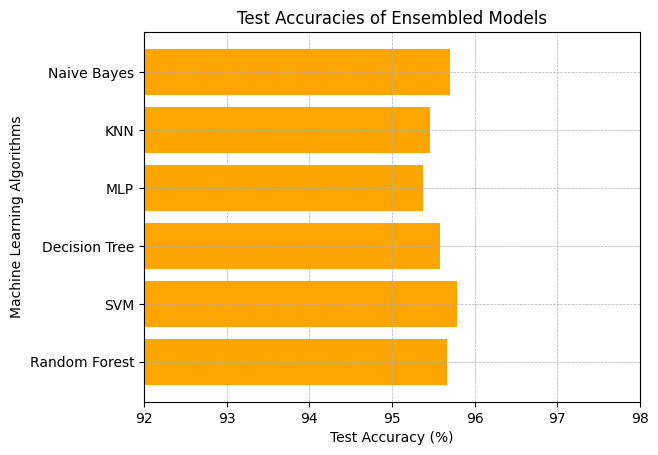

In [32]:
test_accs = [test_acc_rf*100, test_acc_svm*100, test_acc_dt*100, test_acc_mlp*100, test_acc_knn*100, test_acc_nb*100]
model_labels = ['Random Forest', 'SVM', 'Decision Tree', 'MLP', 'KNN', 'Naive Bayes']

plt.barh(model_labels, test_accs, color='orange')
plt.xlabel('Test Accuracy (%)')
plt.ylabel('Machine Learning Algorithms')
plt.xlim(92, 98)
plt.title('Test Accuracies of Ensembled Models')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

In [24]:
chosen_ensemble = mlp_ensemble # TYPE CHOSEN ENSEMBLE HERE

## Saving and loading the pipeline models

When saving the pipeline model it can be a bit difficult to do so and incorporate into the pycharm document but here is the save code below.

In [ ]:
# from keras.models import save_model, load_model
# import joblib

# complete_model.save('complete_model.h5')
# joblib.dump(chosen_ensemble, 'chosen_ensemble.joblib')

# # And loading them would be like this below

# complete_model = load_model('complete_model.h5')
# pipeline = joblib.load('chosen_ensemble.joblib')

# 6. Transfer-learning of pre-trained models

In [25]:
# Load the pre-trained models imports
xception_import = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))
vgg_import = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet_import = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
densenet_import = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

74836368/74836368 [==============================] - 3s 0us/step


In [26]:
def pre_trained_model_learning(model):

  for freezing_layer in model.layers:
    freezing_layer.trainable = False
    
  custom_model_flatten = tf.keras.layers.Flatten()(model.output)
  custom_model_dense1 = tf.keras.layers.Dense(256, activation='relu')(custom_model_flatten)
  custom_model_dense2 = tf.keras.layers.Dense(128, activation='relu')(custom_model_dense1)
  custom_model_output = tf.keras.layers.Dense(3, activation='softmax')(custom_model_dense2)

  model = tf.keras.models.Model(inputs=model.input, outputs=custom_model_output)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

  return model

In [27]:
vgg_model = pre_trained_model_learning(vgg_import)
vgg_history = vgg_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 20s 53ms/step - loss: 0.5200 - accuracy: 0.9250 - val_loss: 0.1588 - val_accuracy: 0.9492
Epoch 2/10
300/300 [==============================] - 18s 59ms/step - loss: 0.0856 - accuracy: 0.9761 - val_loss: 0.1270 - val_accuracy: 0.9617
Epoch 3/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0478 - accuracy: 0.9859 - val_loss: 0.1354 - val_accuracy: 0.9600
Epoch 4/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.1302 - val_accuracy: 0.9650
Epoch 5/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0336 - accuracy: 0.9910 - val_loss: 0.4614 - val_accuracy: 0.9229
Epoch 6/10
300/300 [==============================] - 17s 58ms/step - loss: 0.0809 - accuracy: 0.9810 - val_loss: 0.2699 - val_accuracy: 0.9492
Epoch 7/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0623 - accuracy: 0.9856 - val_loss: 0.2437 - val_accuracy:

In [28]:
xception_model = pre_trained_model_learning(xception_import)
xception_history = xception_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 23s 64ms/step - loss: 6.7147 - accuracy: 0.7900 - val_loss: 1.1344 - val_accuracy: 0.8654
Epoch 2/10
300/300 [==============================] - 16s 55ms/step - loss: 0.8965 - accuracy: 0.8653 - val_loss: 0.4446 - val_accuracy: 0.8846
Epoch 3/10
300/300 [==============================] - 16s 55ms/step - loss: 0.3335 - accuracy: 0.8970 - val_loss: 0.5931 - val_accuracy: 0.8242
Epoch 4/10
300/300 [==============================] - 18s 61ms/step - loss: 0.3711 - accuracy: 0.8953 - val_loss: 0.4672 - val_accuracy: 0.8767
Epoch 5/10
300/300 [==============================] - 16s 54ms/step - loss: 0.2937 - accuracy: 0.9124 - val_loss: 0.4355 - val_accuracy: 0.8921
Epoch 6/10
300/300 [==============================] - 18s 61ms/step - loss: 0.3110 - accuracy: 0.9062 - val_loss: 0.4945 - val_accuracy: 0.8654
Epoch 7/10
300/300 [==============================] - 18s 61ms/step - loss: 0.2753 - accuracy: 0.9094 - val_loss: 0.4730 - val_accuracy:

In [29]:
resnet_model = pre_trained_model_learning(resnet_import)
resnet_history = resnet_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 49s 127ms/step - loss: 0.3831 - accuracy: 0.9392 - val_loss: 0.1597 - val_accuracy: 0.9550
Epoch 2/10
300/300 [==============================] - 35s 116ms/step - loss: 0.0772 - accuracy: 0.9777 - val_loss: 0.1599 - val_accuracy: 0.9625
Epoch 3/10
300/300 [==============================] - 30s 101ms/step - loss: 0.0381 - accuracy: 0.9890 - val_loss: 0.1766 - val_accuracy: 0.9704
Epoch 4/10
300/300 [==============================] - 30s 101ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.1215 - val_accuracy: 0.9688
Epoch 5/10
300/300 [==============================] - 30s 101ms/step - loss: 0.0470 - accuracy: 0.9889 - val_loss: 0.2293 - val_accuracy: 0.9625
Epoch 6/10
300/300 [==============================] - 35s 116ms/step - loss: 0.0233 - accuracy: 0.9935 - val_loss: 0.1691 - val_accuracy: 0.9737
Epoch 7/10
300/300 [==============================] - 35s 116ms/step - loss: 0.0144 - accuracy: 0.9956 - val_loss: 0.2405 - val_ac

In [30]:
desnet_model = pre_trained_model_learning(densenet_import)
desnet_history = desnet_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 40s 84ms/step - loss: 1.8058 - accuracy: 0.8902 - val_loss: 0.3372 - val_accuracy: 0.9346
Epoch 2/10
300/300 [==============================] - 21s 70ms/step - loss: 0.2728 - accuracy: 0.9393 - val_loss: 0.2441 - val_accuracy: 0.9287
Epoch 3/10
300/300 [==============================] - 22s 74ms/step - loss: 0.1713 - accuracy: 0.9527 - val_loss: 0.6266 - val_accuracy: 0.8804
Epoch 4/10
300/300 [==============================] - 21s 69ms/step - loss: 0.1634 - accuracy: 0.9566 - val_loss: 0.1763 - val_accuracy: 0.9475
Epoch 5/10
300/300 [==============================] - 22s 73ms/step - loss: 0.1498 - accuracy: 0.9602 - val_loss: 0.2564 - val_accuracy: 0.9450
Epoch 6/10
300/300 [==============================] - 21s 70ms/step - loss: 0.1662 - accuracy: 0.9594 - val_loss: 0.2327 - val_accuracy: 0.9467
Epoch 7/10
300/300 [==============================] - 22s 74ms/step - loss: 0.1094 - accuracy: 0.9677 - val_loss: 0.1485 - val_accuracy:

# 7. Model Performance Analysis

In [31]:
class_names = ['Fire', 'No Fire or Smoke', 'Smoke',]

**CNN Model Accuracy**

In [33]:
test_loss, test_accuracy = complete_model.evaluate(X_test.reshape(-1,128,128,3), y_test, verbose=2)
print('Accuracy on test dataset:', test_accuracy*100,'%')

75/75 - 4s - loss: 0.1877 - accuracy: 0.9362 - 4s/epoch - 50ms/step
Accuracy on test dataset: 93.62499713897705 %


**CNN-ML Ensembled Pipeline Model Accuracy**

In [34]:
# Pipelined model prediction accuracy

test_preds = chosen_ensemble.predict(test_features)
test_acc = np.mean(test_preds == y_test)
print('Accuracy on test dataset:', test_acc*100,'%')

Accuracy on test dataset: 95.375 %


**CNN Model Prediction on Classes**

In [35]:
predicted_classes  = np.argmax(complete_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

75/75 [==============================] - 4s 49ms/step


In [36]:
predicted_classes_res  = np.argmax(resnet_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

75/75 [==============================] - 9s 78ms/step


In [37]:
predicted_classes_dense  = np.argmax(desnet_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

75/75 [==============================] - 11s 70ms/step


In [38]:
predicted_classes_xception  = np.argmax(xception_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

75/75 [==============================] - 4s 41ms/step


In [39]:
predicted_classes_vgg  = np.argmax(vgg_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

75/75 [==============================] - 3s 40ms/step


**CNN-ML Pipeline Ensemble Prediction on Classes**

In [40]:
predicted_classes_ensemble = chosen_ensemble.predict(test_features)

In [41]:
# Use this for Correct Pipelined-CNN ensembles

correct_ensemble = np.nonzero(predicted_classes_ensemble == y_test)[0]
incorrect_ensemble = np.nonzero(predicted_classes_ensemble != y_test)[0]

print("Correctly predicted classes:", correct_ensemble.shape[0])
print("Incorrectly predicted classes:", incorrect_ensemble.shape[0])

Correctly predicted classes: 2289
Incorrectly predicted classes: 111


In [43]:
# Use this for the Label Encoder/Plain CNN

correct_cnn=np.nonzero(predicted_classes==y_true)[0]
correct_cnn.shape[0]
incorrect_cnn=np.nonzero(predicted_classes!=y_true)[0]

print("Correctly predicted classes:",correct_cnn.shape[0])
print("Incorrectly predicted classes:",incorrect_cnn.shape[0])

Correctly predicted classes: 2310
Incorrectly predicted classes: 90


**Precision, Recall and F1 Score Plain CNN**

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score

num_classes = 3
precision_cnn = precision_score(y_true, predicted_classes, average=None)
recall_cnn = recall_score(y_true, predicted_classes, average=None)
f1score_cnn = f1_score(y_true, predicted_classes, average=None)

In [64]:
for score_cnn in range(num_classes):
    print(f"Class {score_cnn+1} - Precision: {precision_cnn[score_cnn]:.2f}%, Recall:, {recall_cnn[score_cnn]:.2f}%, F1 Score:, {f1score_cnn[score_cnn]:.2f}%")

Class 1 - Precision: 0.87%, Recall:, 0.96%, F1 Score:, 0.91%
Class 2 - Precision: 0.96%, Recall:, 0.85%, F1 Score:, 0.90%
Class 3 - Precision: 1.00%, Recall:, 1.00%, F1 Score:, 1.00%


**Precision, Recall and F1 Score Pipelined CNN-Ensemble Models**

In [65]:
precision_en = precision_score(y_true, predicted_classes_ensemble, average=None)
recall_en = recall_score(y_true, predicted_classes_ensemble, average=None)
f1score_en = f1_score(y_true, predicted_classes_ensemble, average=None)

In [66]:
for score_en in range(num_classes):
    print(f"Class {score_en+1} - Precision: {precision_en[score_en]:.2f}%, Recall: {recall_en[score_en]:.2f}%, F1 Score: {f1score_en[score_en]:.2f}%")

Class 1 - Precision: 0.96%, Recall: 0.91%, F1 Score: 0.93%
Class 2 - Precision: 0.91%, Recall: 0.96%, F1 Score: 0.93%
Class 3 - Precision: 1.00%, Recall: 1.00%, F1 Score: 1.00%


**ALL MODELS PRE-EXISTING**

In [73]:
num_classes = 3
precision_cnn = precision_score(y_true, predicted_classes_res, average=None)
recall_cnn = recall_score(y_true, predicted_classes_res, average=None)
f1score_cnn = f1_score(y_true, predicted_classes_res, average=None)

print("RESNET MODEL")
for score_cnn in range(num_classes):
    print(f"Class {score_cnn+1} - Precision: {precision_cnn[score_cnn]:.2f}%, Recall:, {recall_cnn[score_cnn]:.2f}%, F1 Score:, {f1score_cnn[score_cnn]:.2f}%")

num_classes = 3
precision_cnn = precision_score(y_true, predicted_classes_dense, average=None)
recall_cnn = recall_score(y_true, predicted_classes_dense, average=None)
f1score_cnn = f1_score(y_true, predicted_classes_dense, average=None)

print("DENSENET MODEL")
for score_cnn in range(num_classes):
    print(f"Class {score_cnn+1} - Precision: {precision_cnn[score_cnn]:.2f}%, Recall:, {recall_cnn[score_cnn]:.2f}%, F1 Score:, {f1score_cnn[score_cnn]:.2f}%")

num_classes = 3
precision_cnn = precision_score(y_true, predicted_classes_xception, average=None)
recall_cnn = recall_score(y_true, predicted_classes_xception, average=None)
f1score_cnn = f1_score(y_true, predicted_classes_xception, average=None)

print("XCEPTION MODEL")
for score_cnn in range(num_classes):
    print(f"Class {score_cnn+1} - Precision: {precision_cnn[score_cnn]:.2f}%, Recall:, {recall_cnn[score_cnn]:.2f}%, F1 Score:, {f1score_cnn[score_cnn]:.2f}%")

num_classes = 3
precision_cnn = precision_score(y_true, predicted_classes_vgg, average=None)
recall_cnn = recall_score(y_true, predicted_classes_vgg, average=None)
f1score_cnn = f1_score(y_true, predicted_classes_vgg, average=None)

print("VGG MODEL")
for score_cnn in range(num_classes):
    print(f"Class {score_cnn+1} - Precision: {precision_cnn[score_cnn]:.2f}%, Recall:, {recall_cnn[score_cnn]:.2f}%, F1 Score:, {f1score_cnn[score_cnn]:.2f}%")

RESNET MODEL
Class 1 - Precision: 0.99%, Recall:, 0.90%, F1 Score:, 0.94%
Class 2 - Precision: 0.90%, Recall:, 0.99%, F1 Score:, 0.95%
Class 3 - Precision: 1.00%, Recall:, 1.00%, F1 Score:, 1.00%
DENSENET MODEL
Class 1 - Precision: 0.89%, Recall:, 0.95%, F1 Score:, 0.92%
Class 2 - Precision: 0.94%, Recall:, 0.88%, F1 Score:, 0.91%
Class 3 - Precision: 1.00%, Recall:, 1.00%, F1 Score:, 1.00%
XCEPTION MODEL
Class 1 - Precision: 0.87%, Recall:, 0.83%, F1 Score:, 0.85%
Class 2 - Precision: 0.83%, Recall:, 0.86%, F1 Score:, 0.85%
Class 3 - Precision: 0.98%, Recall:, 1.00%, F1 Score:, 0.99%
VGG MODEL
Class 1 - Precision: 0.94%, Recall:, 0.95%, F1 Score:, 0.95%
Class 2 - Precision: 0.95%, Recall:, 0.94%, F1 Score:, 0.94%
Class 3 - Precision: 1.00%, Recall:, 1.00%, F1 Score:, 1.00%


## Confusion Matrices

In [54]:
from sklearn.metrics import confusion_matrix

conf_mat_cnn = confusion_matrix(y_true, predicted_classes_dense)
conf_mat_ensemble = confusion_matrix(y_true, predicted_classes_ensemble)

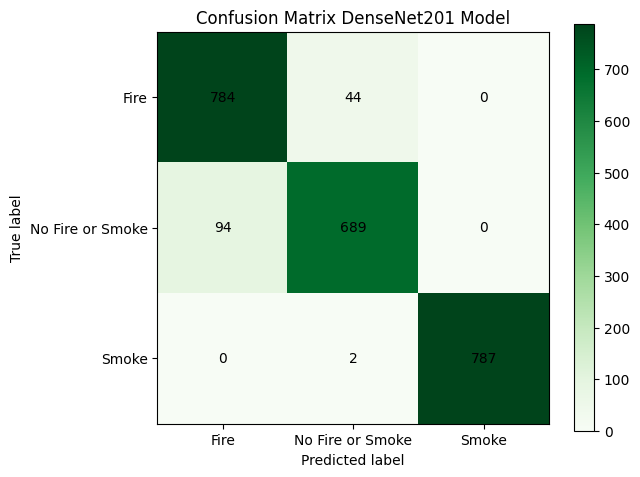

In [55]:
# PLAIN CNN

figs, axes = plt.subplots()
plot = axes.imshow(conf_mat_cnn, cmap=plt.cm.Greens)
axes.figure.colorbar(plot, ax=axes)

# Assigning the right predicted or true label either side of the Confusion Matrix
axes.set(xticks=np.arange(conf_mat_cnn.shape[1]), yticks=np.arange(conf_mat_cnn.shape[0]), xticklabels=class_names, yticklabels=class_names, ylabel='True label', xlabel='Predicted label')

# Plotting the numbers for the CNN model through the loop
for row_cnn in range(conf_mat_cnn.shape[0]):
    for col_cnn in range(conf_mat_cnn.shape[1]):
        axes.text(col_cnn, row_cnn,

                  # Used to change the number display 
                  format(conf_mat_cnn[row_cnn, col_cnn]), 
                  ha="center", 
                  va="center", 
                  color="black")
        
figs.tight_layout()
axes.set_title("Confusion Matrix DenseNet201 Model"); pass

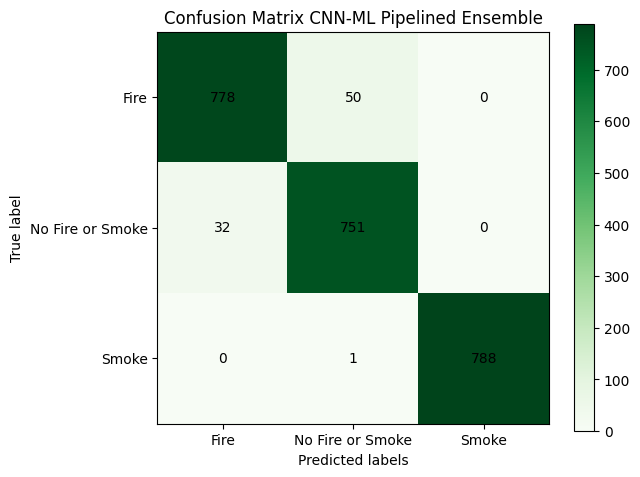

In [111]:
# CNN PIPELINED ENSEMBLE

figs, axes = plt.subplots()
plot = axes.imshow(conf_mat_ensemble, cmap=plt.cm.Greens)
axes.figure.colorbar(plot, ax=axes)

axes.set(xticks=np.arange(conf_mat_ensemble.shape[1]), yticks=np.arange(conf_mat_ensemble.shape[0]), xticklabels=class_names, yticklabels=class_names, ylabel='True label', xlabel='Predicted labels')

for row_ensemble in range(conf_mat_ensemble.shape[0]):
    for col_ensemble in range(conf_mat_ensemble.shape[1]):
        axes.text(col_ensemble, row_ensemble, 
                  format(conf_mat_ensemble[row_ensemble, col_ensemble]), 
                  ha="center", 
                  va="center", 
                  color="black")
        
figs.tight_layout()
axes.set_title("Confusion Matrix CNN-ML Pipelined Ensemble"); pass

## Showing the plain correctly and incorrectly predicted imagery

In [ ]:
## Plotting the train and test imagery
def plot_plain_images(data_index):
    f, ax = plt.subplots(3, 3, figsize=(18,8))

    for i, indx in enumerate(data_index[:9]):
        ax[i//3, i%3].imshow(X_test[indx].reshape(128, 128, 3), cmap='gray')
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title("True Label: {}, Predicted Label: {}".format(class_names[y_test[indx]],class_names[predicted_classes[indx]]))
    plt.show()

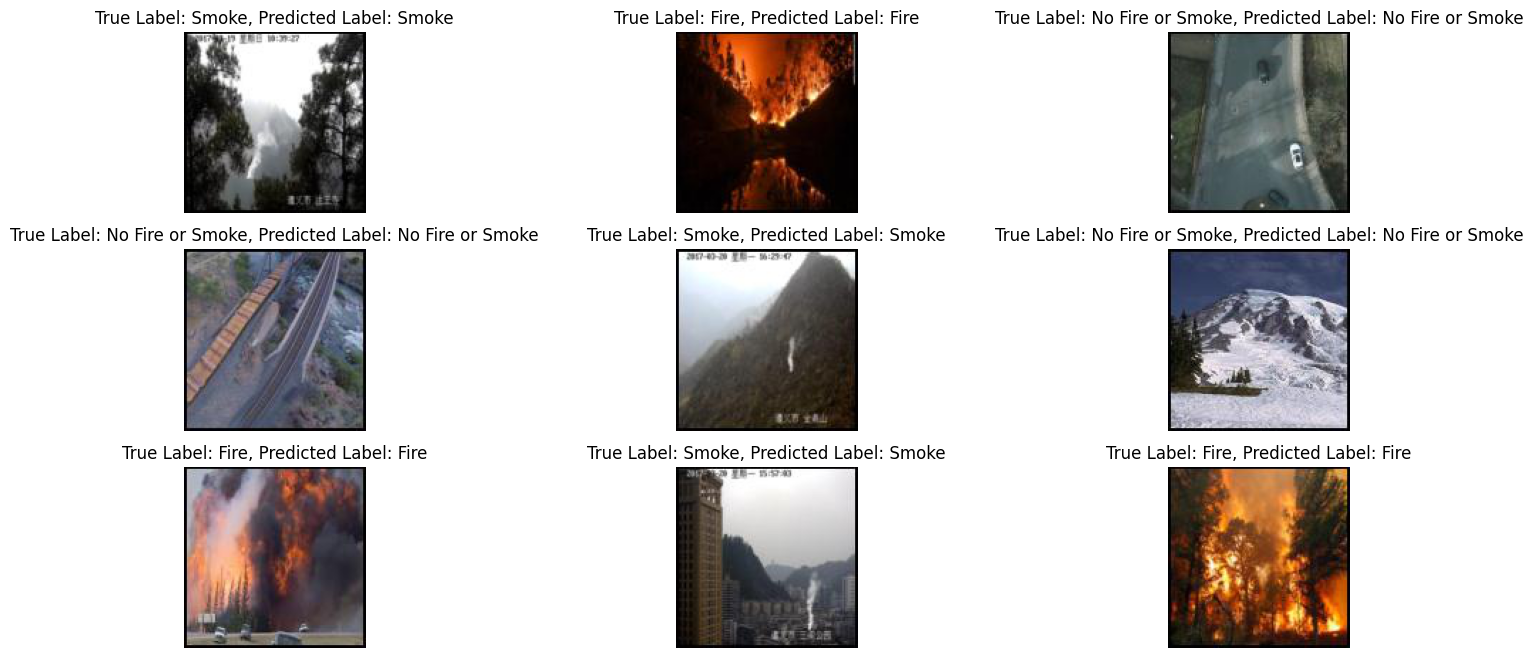

In [ ]:
plot_plain_images(correct_cnn[:10])

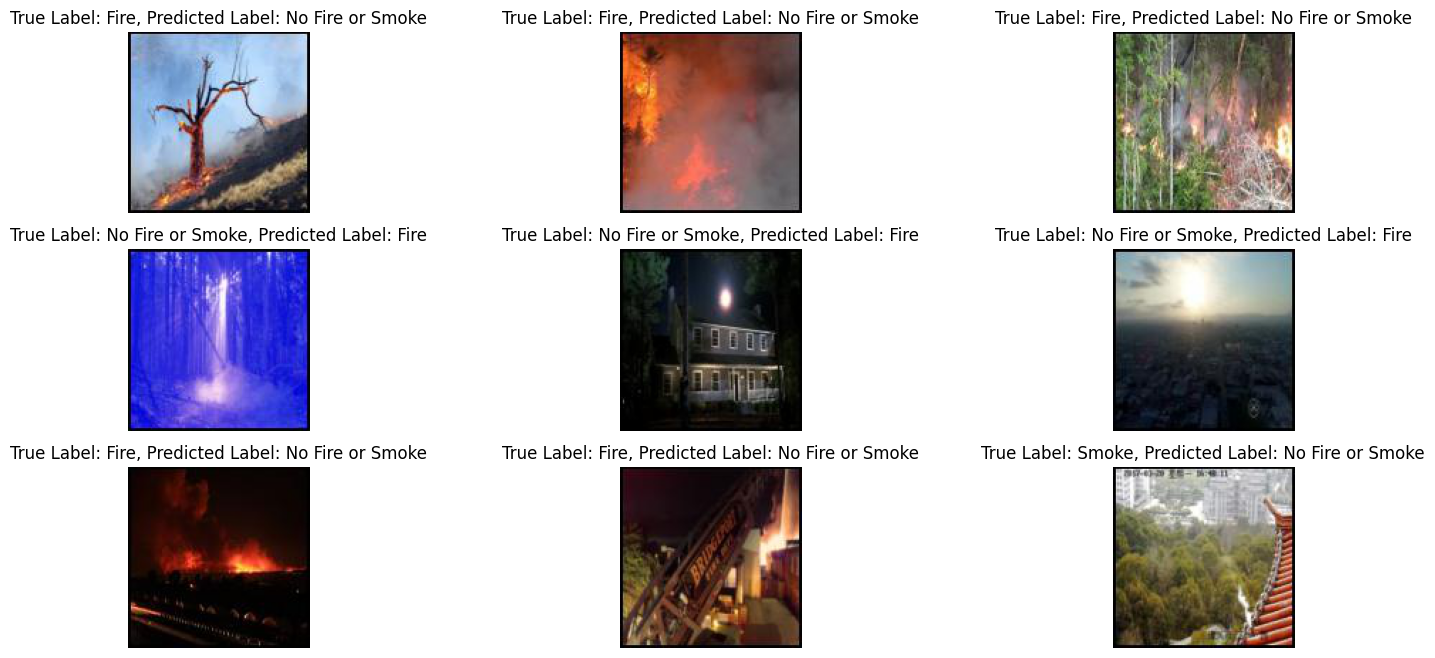

In [ ]:
plot_plain_images(incorrect_cnn[:10])

**Save the h5 and joblib pipelined model file**

In [ ]:
# tf.keras.models.save_model(complete_model, 'models/complete_custom_cnn.h5')

In [ ]:
# joblib.dump(chosen_ensemble, 'models/chosen_ensemble.joblib')

In [ ]:
# !git status

In [ ]:
# !git add .

In [ ]:
# !git commit -m "New model added"

In [ ]:
# !git push

# 8. Visualisations

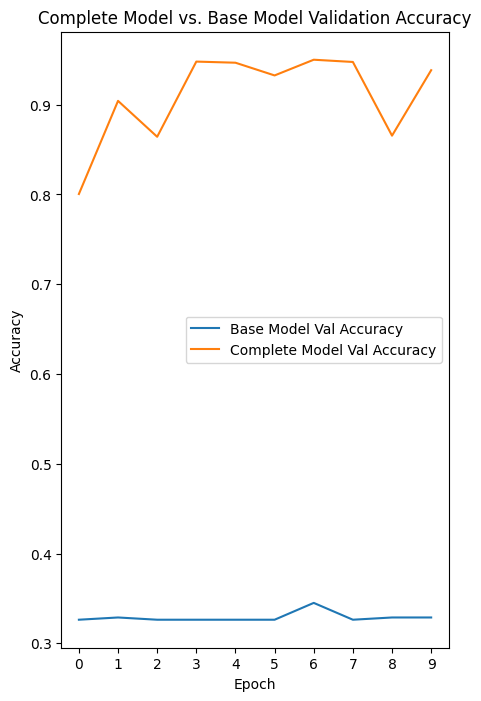

In [ ]:
plt.figure(figsize=(5, 8))

plt.plot(history_base.history['val_accuracy'], label='Base Model Val Accuracy')
plt.plot(history_complete.history['val_accuracy'], label='Complete Model Val Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, 10))
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Complete Model vs. Base Model Validation Accuracy')
plt.show()

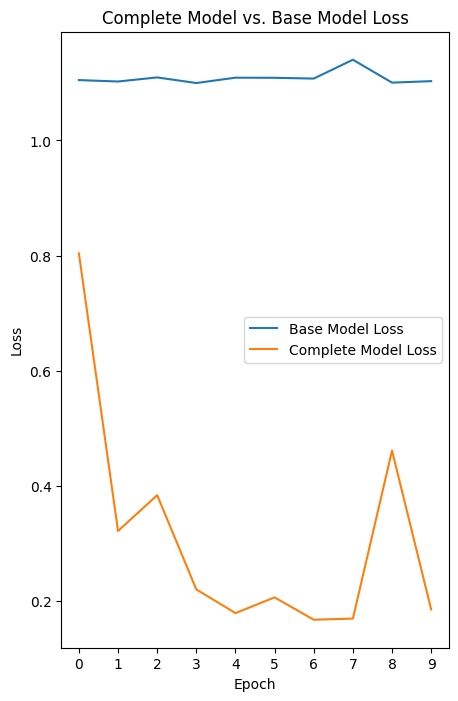

In [ ]:
plt.figure(figsize=(5, 8))

plt.plot(history_base.history['val_loss'], label='Base Model Loss')
plt.plot(history_complete.history['val_loss'], label='Complete Model Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, 10))
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Complete Model vs. Base Model Loss')
plt.show()

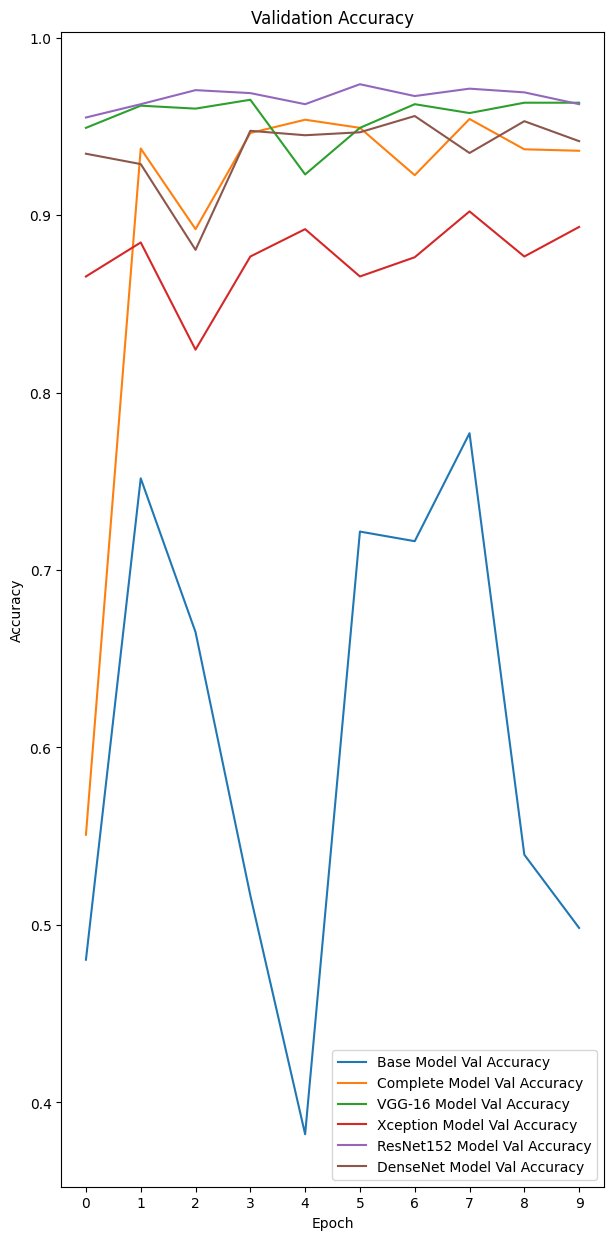

In [60]:
plt.figure(figsize=(7, 15))

plt.plot(history_base.history['val_accuracy'], label='Base Model Val Accuracy')
plt.plot(history_complete.history['val_accuracy'], label='Complete Model Val Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='VGG-16 Model Val Accuracy')
plt.plot(xception_history.history['val_accuracy'], label='Xception Model Val Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet152 Model Val Accuracy')
plt.plot(desnet_history.history['val_accuracy'], label='DenseNet Model Val Accuracy')

plt.xlabel('Epoch')
plt.xticks(range(0, 10))
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Validation Accuracy')
plt.show()

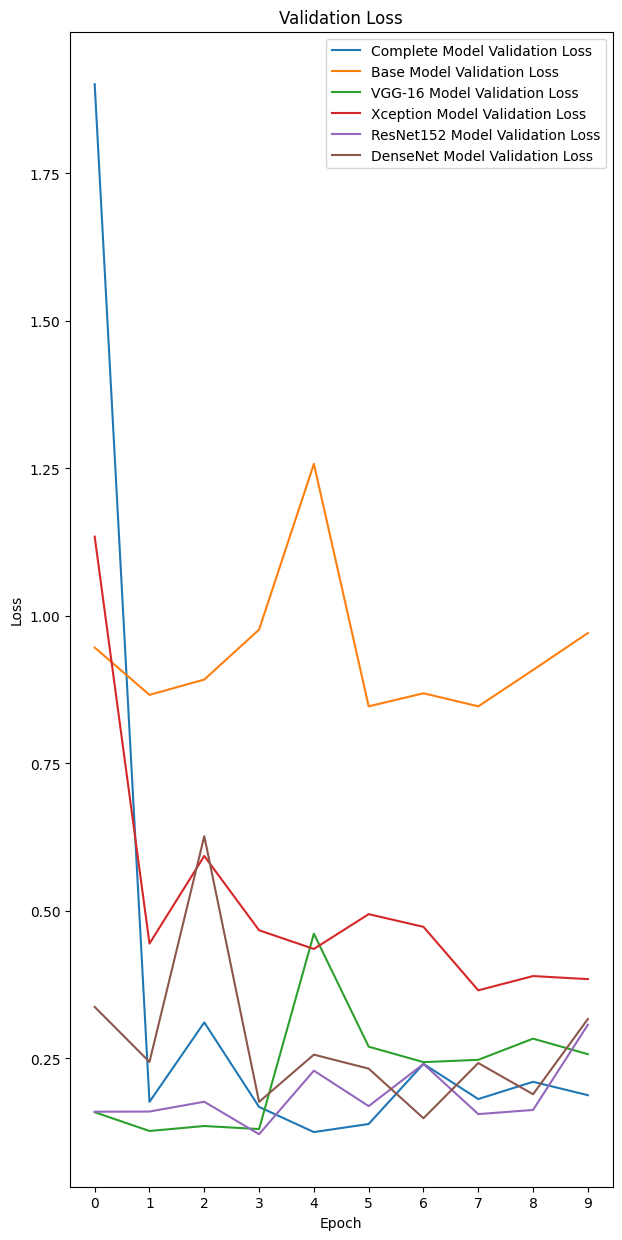

In [61]:
plt.figure(figsize=(7, 15))

plt.plot(history_complete.history['val_loss'], label='Complete Model Validation Loss')
plt.plot(history_base.history['val_loss'], label='Base Model Validation Loss')
plt.plot(vgg_history.history['val_loss'], label='VGG-16 Model Validation Loss')
plt.plot(xception_history.history['val_loss'], label='Xception Model Validation Loss')
plt.plot(resnet_history.history['val_loss'], label='ResNet152 Model Validation Loss')
plt.plot(desnet_history.history['val_loss'], label='DenseNet Model Validation Loss')

plt.xlabel('Epoch')
plt.xticks(range(0, 10))
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Validation Loss')
plt.show()

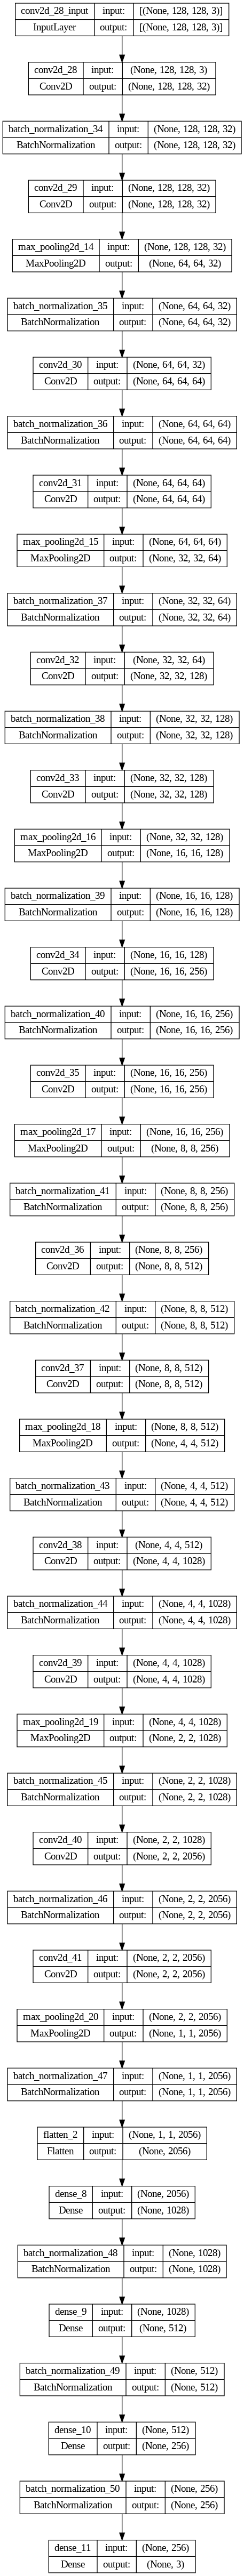

In [ ]:
from keras.utils import plot_model

# Complete model architecture visualising layers and shapes

# draw the plot using seaborn
plot_model(complete_model, show_shapes=True, show_layer_names=True)

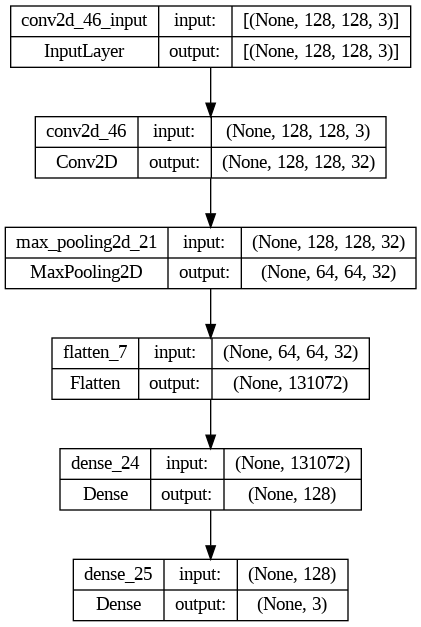

In [ ]:
plot_model(base_model, show_shapes=True, show_layer_names=True)

In [ ]:
type(complete_model)

keras.engine.sequential.Sequential

In [ ]:
complete_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_34 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_35 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                      

In [ ]:
xception_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 50.8 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-634ye_sc
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-634ye_sc
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


In [ ]:
import visualkeras

In [ ]:
# Visualisig our base model

visualkeras.layered_view(base_model, legend=True)

NameError: ignored

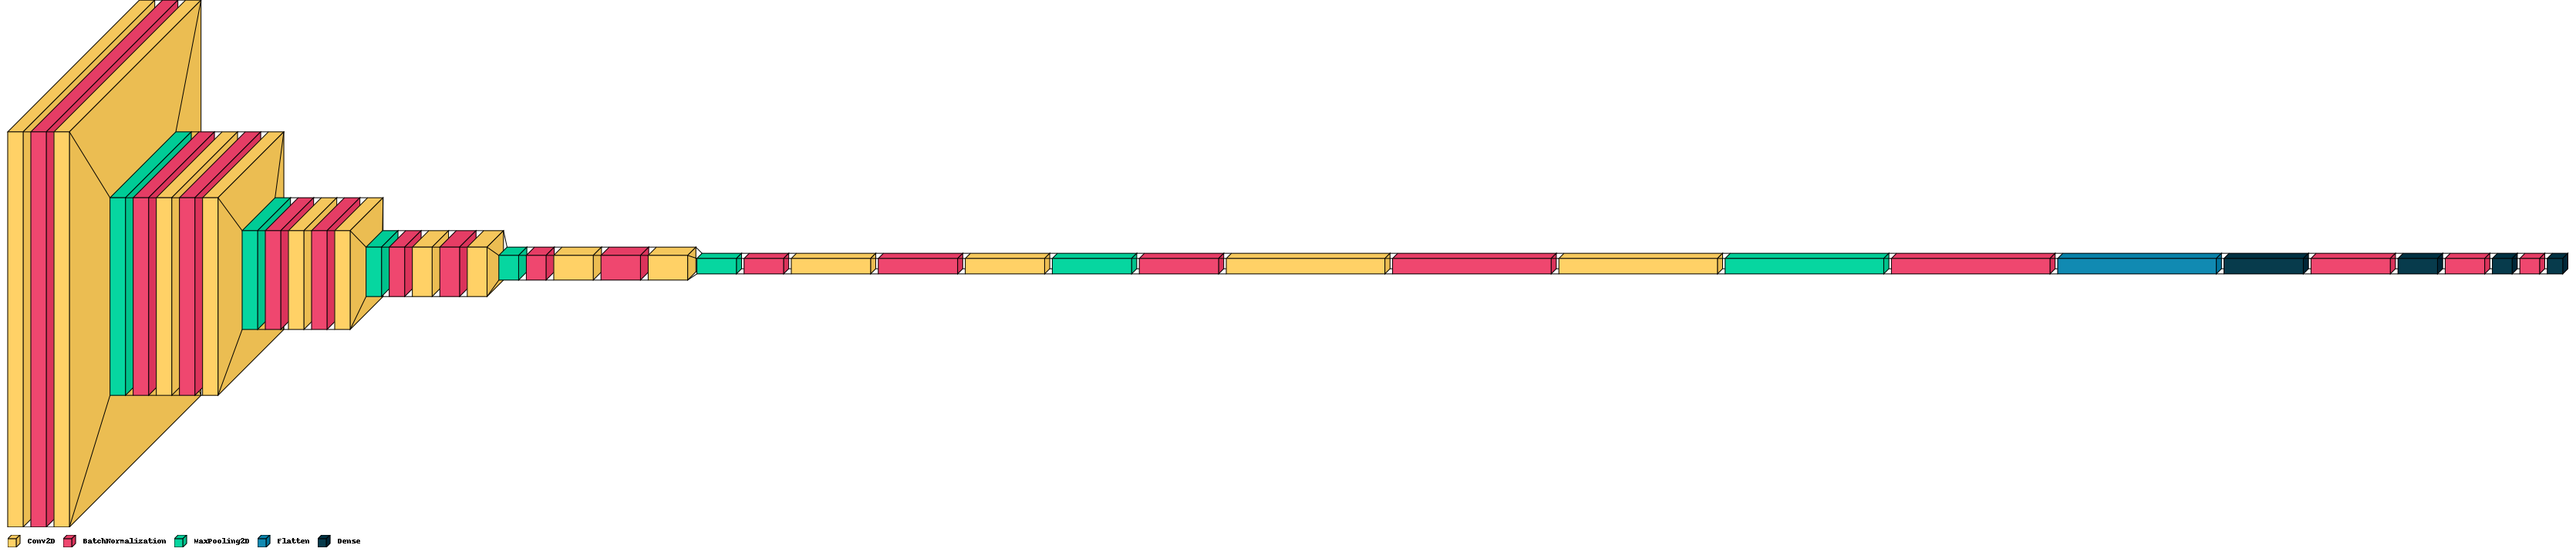

In [ ]:
visualkeras.layered_view(complete_model, legend=True)

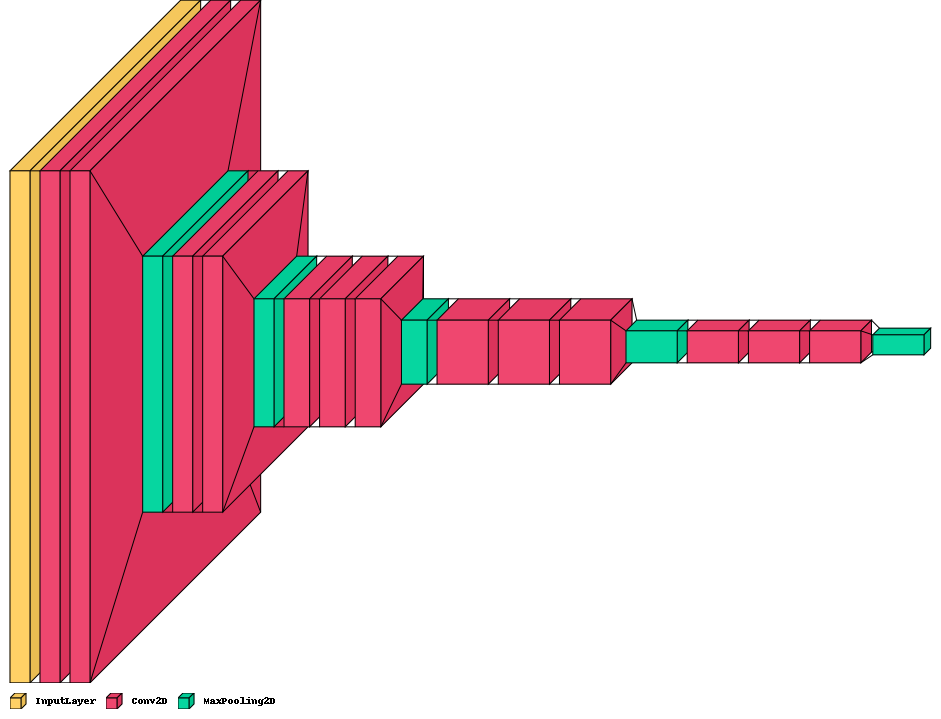

In [ ]:
visualkeras.layered_view(vgg_import, legend=True)

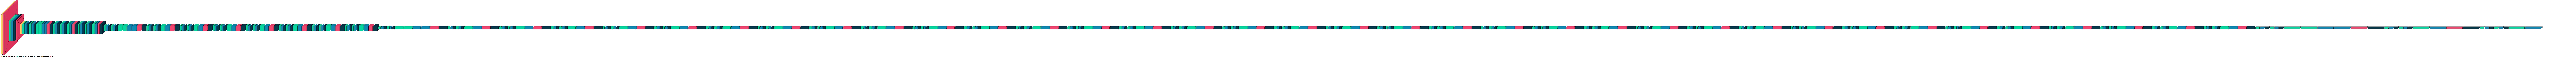

In [ ]:
visualkeras.layered_view(resnet_import, legend=True)

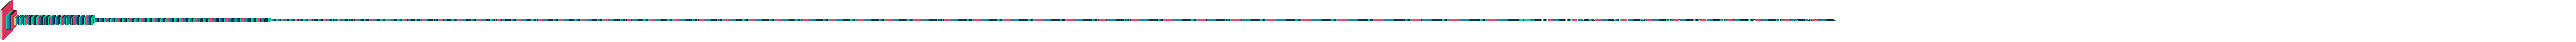

In [ ]:
visualkeras.layered_view(densenet_import, legend=True)

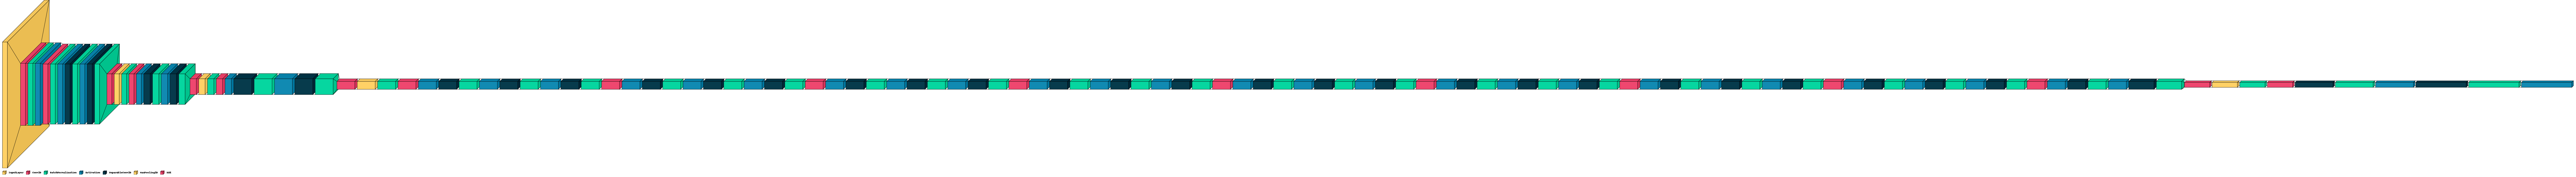

In [ ]:
visualkeras.layered_view(xception_import, legend=True)